# simulation of PSF smearing correction maps and test run 
- Creating ring as in Ma+2023 and convolving with observed PSF, calculating the 'correction matrix' f for different PSF size (filters) and cuts of the PSF image. 
- also calculating correction matrix for the elliptical ring with 

    
We have to equal all <0 values in qphi to 0 because in the analysis process data we focus only on qphi>=0. This values corerspond to the azimutal polarisation and also deconvolution work only for the >0.

The PSF smearing is based on the corresponding observational PSF for the each target and each corresponding camera

Initial functions:

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
import pandas as pd
from PIL import Image, ImageChops
import sys
import math
import seaborn as sns
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import rescale, resize, downscale_local_mean
import cv2  
import functions as f
import textwrap

def deconvolving(image, psf, N_decon):
    psf_fliped=np.flip(psf)

    decon = np.copy(image)  # Create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
    for i in range(0, N_decon):  # now iterate
        print ('deconvolution step ' + str(i))  # just some control output

        decon = decon*(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))
        if i==0:
            deconvolved1=decon
            crit=1
        if i>=1:
            crit=compare(decon,deconvolved1)        
            deconvolved1=decon

        if (crit<0.015):
            N_final=i
            break    
    return decon, crit

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, d, -d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        #CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, d, -d))
        #ax.clabel(CS, inline=True, fontsize=10)
        wrapped_title = "\n".join(textwrap.wrap(labels[key], width=25))
        ax.set_title(wrapped_title)
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    specific_folder=figfolder+'models/'
    try:
    #Create target Directory
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
   
    plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference
    
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)  

    return m_norm

def Loadimages_other(ifile):

    dir =dirdat_model
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            imageItot = hduli[0].data[0]
            imageQ = hduli[0].data[1]
            imageU = hduli[0].data[2]
            imageI = hduli[0].data[3]
            
            n = imageQ.shape[0]

    return imageItot, imageQ,imageU,imageI, n, hduli

def Loadimages(star,fittype):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/reduced_pdi/star_pol_subtr/'
    
    if star=='u_mon_combined':
        dir =dirdat + star + '/reduced_pdi_combined/star_pol_subtr/' #for combined set
    if fittype=='I_tot':
        ifile = '*I_pol_star_pol_subtr.fits'
    else:
        ifile = '*'+fittype+'_star_pol_subtr.fits'
    psfile = '*I_tot.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            #image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']
            
            
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSF = hdulPSF['Primary'].data
            
    return image, PSF,n,hduli


def plotImage(image1, lim1,ps):
    n = image1.shape[0]
    
    fig, ax = plt.subplots()
    image = image1#np.arcsinh(image1)#np.copy(image1)#
    if ps==12.27:
        lim=lim1*1.0
    else:
        lim=lim1*12.27/3.6
    max = np.max(image[int(n/2-2*lim/2):int(n/2+2*lim/2),int(n/2-2*lim/2):int(n/2+2*lim/2)])
    min=np.min(image[int(n/2-2*lim/2):int(n/2+2*lim/2),int(n/2-2*lim/2):int(n/2+2*lim/2)])
    d = n * ps / 2
    #plt.imshow(image, extent=(-d, d, d, -d))
    plt.imshow(image,vmin=min, vmax=max, extent=(-d, d, d, -d))
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout(pad=3.0)
    plt.show()
    plt.close()
    
def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

 ## Folder settings

In [29]:
dirdat = '/media/kateryna/Data_Lin/PhD/IRDAP_reduction/kluska_0102.D-0696(A)/0-3_reduction/'

figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'PSF_models/'
stars=['HD75885','HD71253','HD94680','HD96314','HD98025']
#stars=['HD71253','HD96314']
#disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
sci_of_ref={'HD75885':'AR_Pup','HD71253':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226'} #the corresponding scientific targets, SPHERE proposals
irdis_of_ref={'HD71253':'u_mon_combined','HD96314':'hr4049'} #the corresponding scientific targets, SPHERE proposals

disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star = stars[1]

if star=='HD71253' or star=='HD96314':
    bands=['V','I','H']
else:
    bands=['V','I']
#bands=['H']


try:
# Create target Directory
   os.mkdir(figfolder)
except FileExistsError:
   print("Directory " , figfolder ,  " already exists")
figfolder=figfolder+star+'/'
try:
# Create target Directory
   os.mkdir(figfolder)
except FileExistsError:
   print("Directory " , figfolder ,  " already exists")



#fittypes=['I_pol','Q_phi']


N_decon = 20


Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/HD71253/  already exists


## Creating 1-pixel width ring and convolving with observational PSF for V,I bands
Checking for different cut of the PSF array
Resulting array of correcting coef is saved to fits files

In [3]:
ring_H=np.zeros((1024,1024))
f_pi_i=np.ones((1024,1024))
f_pi_v=np.ones((1024,1024))
f_pi_h=np.ones((1024,1024))
f_q_i=np.ones((1024,1024))
f_q_v=np.ones((1024,1024))
f_q_h=np.ones((1024,1024))

n_model=1024
shift=int((n_model)/2.)
x = np.linspace(-shift+1, shift, num=n_model)
y = np.linspace(-shift+1, shift, num=n_model)
x=x-0.5
y=y-0.5

X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
#calculating angle for azimuthal polarisation
phi= np.arctan(Y/X)

dataframes={}


#[30,40,50,60,70,80,90,100,150,200]
for psf_cut in [50]:#,50,90]:
    print(psf_cut)
    #downloading PSF files
    if star=='HD71253' or star=='HD96314':

        image_sphere, psf_H, n,hdul= Loadimages(irdis_of_ref[star],'Q_phi')
        psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_H=psf_H_short#/np.sum(psf_H_short)

    figfolder_psf='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+star+'/'

    psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits') 
    n=psf_I.shape[0]
    psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_V=psf_V_short#/np.sum(psf_V_short)
    psf_I=psf_I_short#/np.sum(psf_I_short)

    
    df = pd.DataFrame(columns=['radius_pix','radius_H', 'sum_Qphi_H','sum_Uphi_H','f_H','radius_V',  'sum_Qphi_V','sum_Uphi_V','f_V',
                              'radius_I','sum_Qphi_I','sum_Uphi_I','f_I'])
    index=-1
    for radius in range(2,150,1):
        print(radius)
        df.empty
        index=index+1
        ring_H=np.zeros((1024,1024))

        ring_H[(R<=radius)*(R>radius-1)]=1
        df.loc[index,'radius_pix']=radius

        ring_H_q=ring_H*np.cos(2*phi)
        ring_H_u=ring_H*np.sin(2*phi)

        lim=20    

        # qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
        # uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot
        
        for band in bands:
            if band=='I':
                ps=3.6
                psf=psf_I
            elif band=='V':
                ps=3.6
                psf=psf_V
            elif band=='H':
                ps=12.27
                psf=psf_H
           

            Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       
            U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       


            Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
            U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            #print('Q_phi',np.sum(Q_phi_conv))
            df.loc[index,'sum_Qphi_'+band]=np.sum(Q_phi_conv)
            df.loc[index,'radius_'+band]=radius*ps

            df.loc[index,'sum_Uphi_'+band]=np.sum(U_phi_conv)
            df.loc[index,'f_'+band]=np.sum(ring_H)/np.sum(Q_phi_conv)
            dataframes[f'df_{psf_cut}'] = df
            
            if band=='I':
                f_q_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                f_pi_i[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
            elif band=='V':
                f_q_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                f_pi_v[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
            elif band=='H':
                f_q_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(Q_phi_conv)
                f_pi_h[(R<=radius)*(R>radius-1)]=np.sum(ring_H)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
   
    df.to_csv(figfolder+f'df_{psf_cut}'+'.csv')
    out_fits = fits.HDUList(fits.PrimaryHDU(f_q_i))                  # create output fits structure
    out_fits.writeto(figfolder+'Iband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    
    out_fits = fits.HDUList(fits.PrimaryHDU(f_q_v))                  # create output fits structure
    out_fits.writeto(figfolder+'Vband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    if star=='HD71253' or star=='HD96314':

        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
        out_fits.writeto(figfolder+'Hband_qphi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

    out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_i))                  # create output fits structure
    out_fits.writeto(figfolder+'Iband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    
    out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_v))                  # create output fits structure
    out_fits.writeto(figfolder+'Vband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    if star=='HD71253' or star=='HD96314':

        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_h))                  # create output fits structure
        out_fits.writeto(figfolder+'Hband_pi_circular_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output


50
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


## Plotting radial dependence of the correcting coef for different filters and cuts

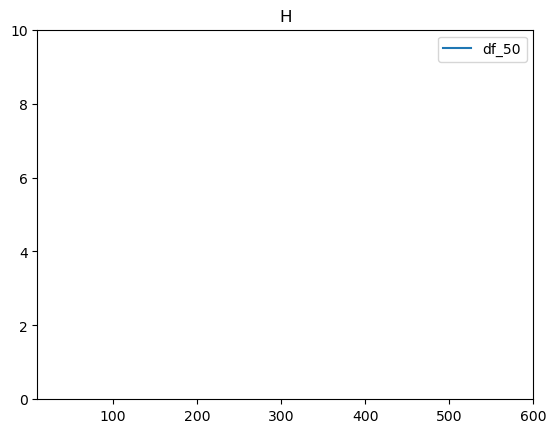

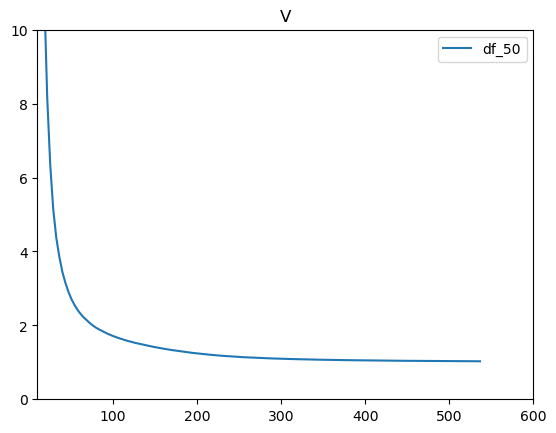

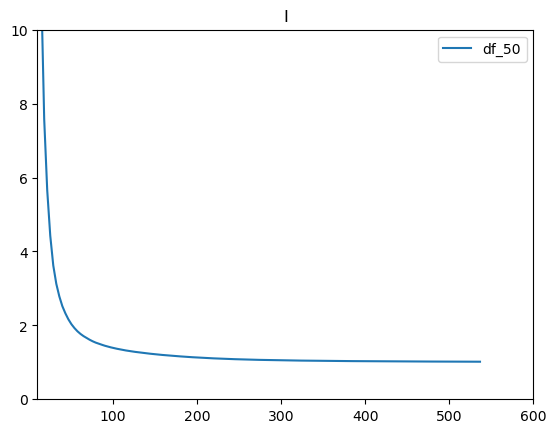

In [4]:
#df=dataframes['df_30']
dataframes={}

for psf_cut in [50]:
    dataframes[f'df_{psf_cut}'] = pd.read_csv(figfolder+f'df_{psf_cut}'+'.csv')

for key,df in dataframes.items():
    
    plt.plot(df['radius_H'],df['f_H'],label=key)
    plt.title('H')
    plt.ylim(0,10)
    plt.xlim(10,600) 
    plt.legend()
plt.show()
plt.close()
    
for key,df in dataframes.items():
    
    plt.plot(df['radius_V'],df['f_V'],label=key)
    plt.title('V')
    plt.ylim(0,10)
    plt.xlim(10,600)
    plt.legend()
plt.show()
plt.close()

for key,df in dataframes.items():
    
    plt.plot(df['radius_I'],df['f_I'],label=key)
    plt.title('I')
    plt.ylim(0,10)
    plt.xlim(10,600)
    plt.legend()
plt.show()
plt.close()

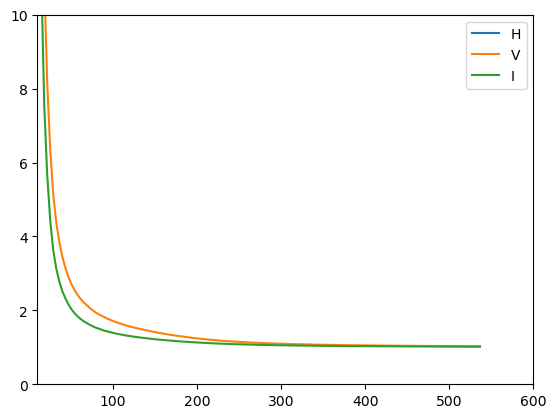

In [5]:
#df=dataframes['df_30']
#plt.plot(df['radius_H'],df['f_H'],label='df_30')
key='df_50'
df=dataframes[key]
plt.plot(df['radius_H'],df['f_H'],label='H')
plt.plot(df['radius_V'],df['f_V'],label='V')
plt.plot(df['radius_I'],df['f_I'],label='I')
plt.ylim(0,10)
plt.xlim(10,600) 
plt.legend()
    

## Simulating 'face-on' disk and testing the correction
convolution -> deconvolution -> PSF smearing correction

50
V
deconvolution step 0
deconvolution step 1


/tmp/ipykernel_132663/2369673230.py:32: RuntimeWarning: divide by zero encountered in divide
  decon = decon*(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))


deconvolution step 2
deconvolution step 3
deconvolution step 4


/tmp/ipykernel_132663/2369673230.py:32: RuntimeWarning: invalid value encountered in divide
  decon = decon*(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))


deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
deconvolution step 15
deconvolution step 16
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
deconvolution step 15
deconvolution step 16
deconvolution step 17
0.014092219745367689


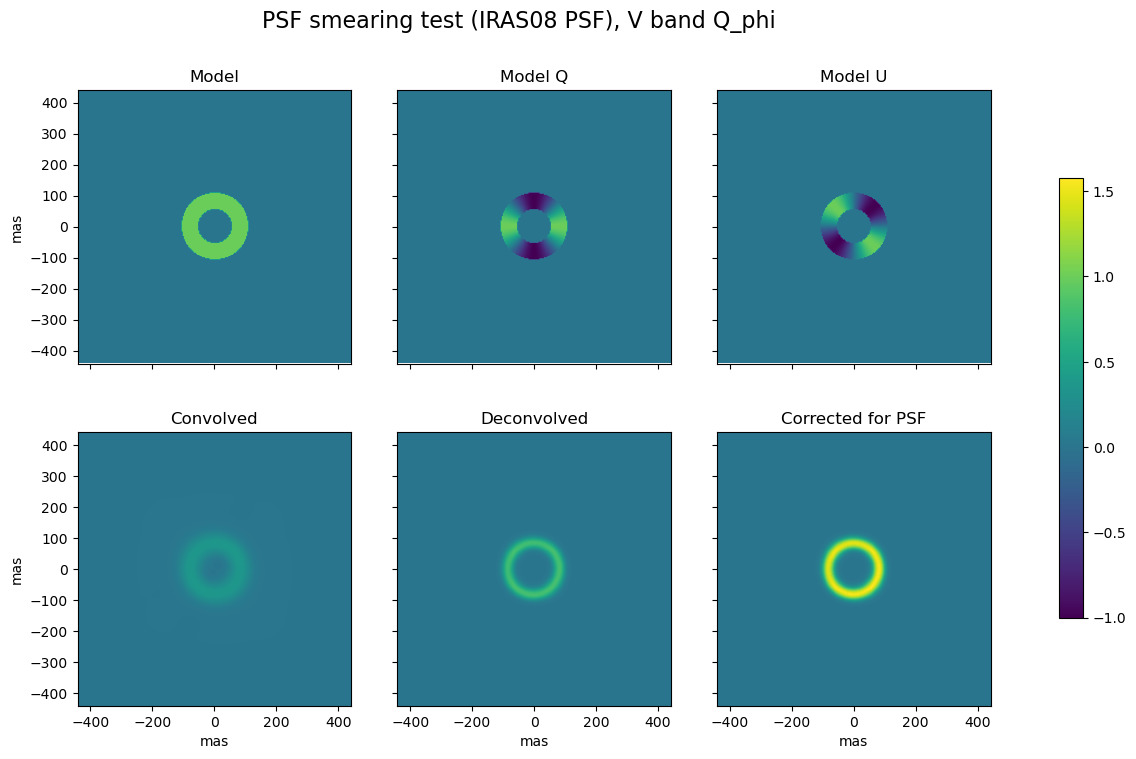

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.5325144465643891
Correction efficion  0.9978158273895801
sum_PI
Signal after PSF convolution (as ratio to initial) 0.5391562236996029
Correction efficion  0.9925784170368028
I
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 14
0.014449748140356447


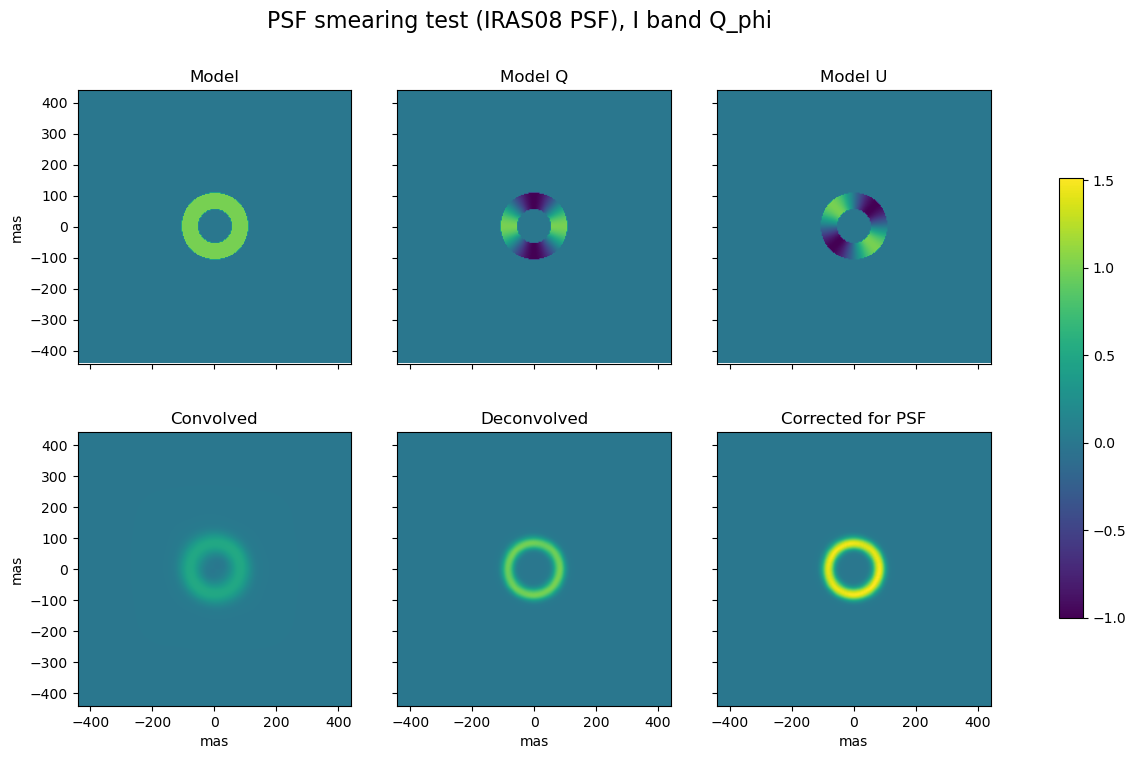

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.6679759261389753
Correction efficion  0.9962087663417764
sum_PI
Signal after PSF convolution (as ratio to initial) 0.6716339470136415
Correction efficion  0.9946664368150433


In [6]:
n_model=1024
shift=int((n_model)/2.)
x = np.linspace(-shift+1, shift, num=n_model)
y = np.linspace(-shift+1, shift, num=n_model)
x=x-0.5
y=y-0.5

X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
#calculating angle for azimuthal polarisation
phi= np.arctan(Y/X)
ring_H=np.zeros((1024,1024))

ring_H[(R<=30)*(R>15)]=1
ring_H_q=ring_H*np.cos(2*phi)
ring_H_u=ring_H*np.sin(2*phi)

lim=20    

qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot
#[30,50,70,90]
for psf_cut in [50]:
    print(psf_cut)
    #downloading PSF files
    # image_sphere, psf_H, n,hdul= Loadimages('iras08544-4431_calib','Q_phi')
    # psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    # psf_H=psf_H_short#/np.sum(psf_H_short)

    figfolder_psf='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+star+'/'  
    psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits') 
    psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_V=psf_V_short#/np.sum(psf_V_short)
    psf_I=psf_I_short#/np.sum(psf_I_short)
    
    
    

    for band in bands:
        print(band)
        if band=='I':
            ps=3.6
            psf=psf_I
        elif band=='V':
            ps=3.6
            psf=psf_V
        elif band=='H':
            ps=12.27
            psf=psf_H
            
        f_q= Loadimage(figfolder,band+'band_qphi_circular_f_psf_'+str(psf_cut)+'.fits')
        f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')
        
        Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       
        U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)   
        
        PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

        Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
        Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16
        U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)
        
       
        
        Q_phi_deconvolved, crit= deconvolving(Q_phi_conv, psf, 25)
        PI_deconvolved, crit= deconvolving(PI_conv, psf, 25)
        
        print(crit)
        
        Q_phi_corrected=Q_phi_deconvolved*f_q
        PI_corrected=PI_deconvolved*f_pi
        
        keys=['orig','orig_q','orig_u',  'conv','decon','corr']
        labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
        data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
        if band=='H':
            cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
        else:
            cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']
        
        
        plot_with_same_color(data, keys, labels ,'Q_phi','PSF smearing test (IRAS08 PSF), '+band+ ' band',10*ps,False,cameras)

        print('sum_Qphi')
        print('Signal after PSF convolution (as ratio to initial)',np.sum(Q_phi_conv)/np.sum(ring_H))
        print('Correction efficion ', np.sum(Q_phi_corrected)/np.sum(ring_H))
        print('sum_PI')
        print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
        print('Correction efficion ', np.sum(PI_corrected)/np.sum(ring_H))

        #print('sum_Qphi')
        #print('Initial ', np.sum(ring_H))
        #print('Convolved',np.sum(Q_phi_conv))
        #print('Corrected',np.sum(Q_phi_corrected))
        #print('sum_PI')
        #print('Initial ', np.sum(ring_H))
        #print('Convolved',np.sum(PI_conv))
        #print('Corrected',np.sum(PI_corrected))
        

## Generating elliptical matrix of corrections

Works better than just circular

### Incl and PA from litr

50
4


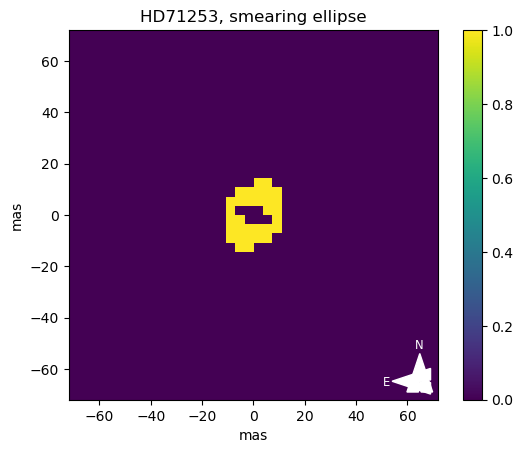

5


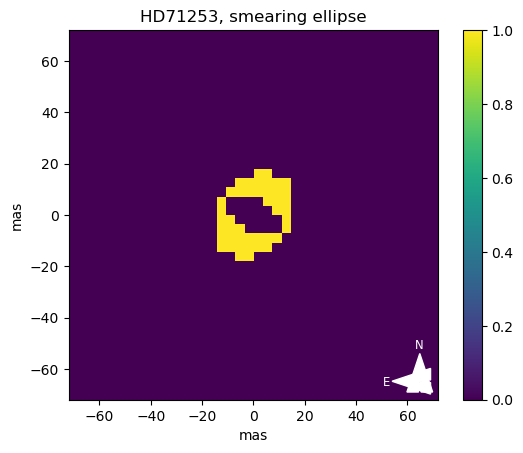

6


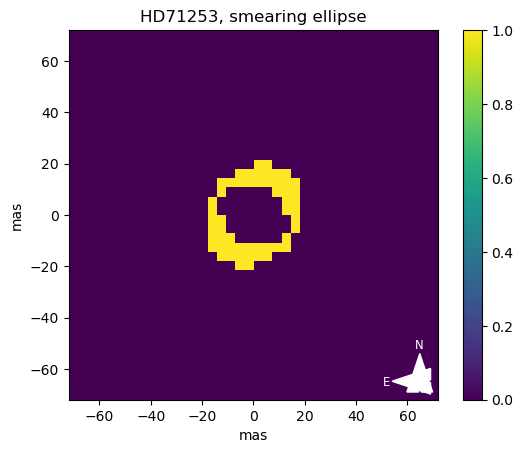

7


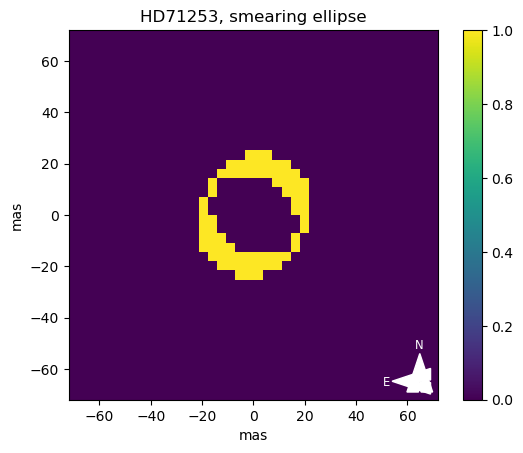

8


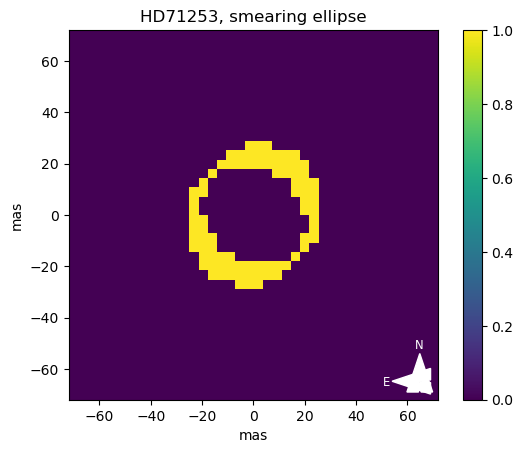

9


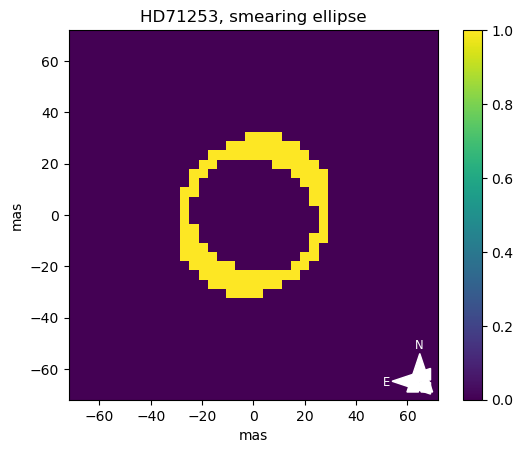

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [4]:

f_pi_i=np.ones((1024,1024))
f_pi_v=np.ones((1024,1024))
f_pi_h=np.ones((1024,1024))
f_q_i=np.ones((1024,1024))
f_q_v=np.ones((1024,1024))
f_q_h=np.ones((1024,1024))

n_model=1024
shift=int((n_model)/2.)
x = np.linspace(-shift+1, shift, num=n_model)
y = np.linspace(-shift+1, shift, num=n_model)
x=x-0.5
y=y-0.5

X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
#calculating angle for azimuthal polarisation
phi= np.arctan(Y/X)

dataframes={}
#disk_incl_pa={'AR_Pup':[75,45],'UMon':[25,144],'V709_Car':[34,13],'HR4049':[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle
#sci_of_ref={'HD75885':'AR_Pup','HD71253':'UMon','HD94680':'V709_Car','HD96314':'HR4049','HD98025':'HR4226'} #the corresponding scientific targets, SPHERE proposals
science_targ=sci_of_ref[star]
incl_pa=disk_incl_pa[science_targ]

 # Define ellipse parameters
center = (0, 0)  # Center coordinates (x, y)

position_angle = incl_pa[1]-90  # Position angle (orientation) of the ellipse (in degrees)
sini=np.cos(np.deg2rad(incl_pa[0]))

#[30,40,50,60,70,80,90,100,150,200]
for psf_cut in [50]:
    print(psf_cut)
    #downloading PSF files
    if star=='HD71253' or star=='HD96314':

        image_sphere, psf_H, n,hdul= Loadimages(irdis_of_ref[star],'Q_phi')
        psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_H=psf_H_short#/np.sum(psf_H_short)
        
    figfolder_psf='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+star+'/'  
    psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits') 
    psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_V=psf_V_short#/np.sum(psf_V_short)
    psf_I=psf_I_short#/np.sum(psf_I_short)

    
    df = pd.DataFrame(columns=['majaxis_pix','majaxis_H', 'sum_Qphi_H','sum_Uphi_H','f_H','majaxis_V',  'sum_Qphi_V','sum_Uphi_V','f_V',
                              'majaxis_I','sum_Qphi_I','sum_Uphi_I','f_I'])
    index=-1
    for maxis in range(4,200,1):
        print(maxis)
        df.empty
        index=index+1
        #print(index)
        if int((maxis)*sini)<1:
            minaxis=1
        else:
            minaxis=int((maxis)*sini)
        # Define the rest of ellipse parameters
        axes = (maxis, minaxis)  # Major and minor axis lengths
        
        # Create an empty array for the ellipse
        ellipse_ring = np.zeros((n_model, n_model))
        # Calculate the ellipse mask with the specified position angle
        a = np.deg2rad(position_angle)
        cos_a = np.cos(a)
        sin_a = np.sin(a)

        # Generate the ellipse mask with rotation
        mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

        # Set the pixels inside the ellipse to 1
        ellipse_ring[mask] = 1

        if int((maxis-1)*sini)>1: #this corrections to avoid when we have just a few pixels for high inclined "ring"
            if minaxis-int((maxis-1)*sini)>=1:
                minaxis=int((maxis-1)*sini)
            else: minaxis=minaxis-1
            
            axes = (maxis-3, minaxis)  # Major and minor axis lengths
            # Generate the ellipse mask with rotation
            mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
            # Set the pixels inside the ellipse to 1
            ellipse_ring[mask] = 0

        df.loc[index,'majaxis_pix']=maxis

        ellipse_ring_q=ellipse_ring*np.cos(2*phi)
        ellipse_ring_u=ellipse_ring*np.sin(2*phi)

        lim=20    

        qphi=(ellipse_ring_q*np.cos(2*phi)+ellipse_ring_u*np.sin(2*phi))#/model_imageItot
        
        
        if maxis<10:
            image = qphi*(R<250)
            fig, ax = plt.subplots()
            f.plottingroutinemas(image,lim,3.6,image.shape[0],star,ax)        
            f.scale_mas(star,ax)  
            plt.title(star+', smearing ellipse') 
            plt.savefig(figfolder+star+'_'+'_smearing_ellipse.jpeg',bbox_inches='tight', pad_inches=0.1)
            plt.show()
            plt.close()
        
        
        
        uphi=(ellipse_ring_q*np.sin(2*phi)-ellipse_ring_u*np.cos(2*phi))#/model_imageItot

        for band in bands:
            if band=='I':
                ps=3.6
                psf=psf_I
            elif band=='V':
                ps=3.6
                psf=psf_V
            elif band=='H':
                ps=12.27
                psf=psf_H

            Q_conv=convolve_fft(ellipse_ring_q, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       
            U_conv=convolve_fft(ellipse_ring_u, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       


            Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
            Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
            U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)

            #print('Q_phi',np.sum(Q_phi_conv))
            df.loc[index,'sum_Qphi_'+band]=np.sum(Q_phi_conv)
            df.loc[index,'majaxis_'+band]=maxis*ps

            df.loc[index,'sum_Uphi_'+band]=np.sum(U_phi_conv)
            df.loc[index,'f_'+band]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
            dataframes[f'df_{psf_cut}'] = df
            
            if band=='I':
                f_q_i[(ellipse_ring*f_q_i)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                f_pi_i[(ellipse_ring*f_pi_i)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
            elif band=='V':
                f_q_v[(ellipse_ring*f_q_v)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                f_pi_v[(ellipse_ring*f_pi_v)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
            elif band=='H':
                f_q_h[(ellipse_ring*f_q_h)==1]=np.sum(ellipse_ring)/np.sum(Q_phi_conv)
                f_pi_h[(ellipse_ring*f_pi_h)==1]=np.sum(ellipse_ring)/np.sum(np.sqrt(Q_conv*Q_conv+U_conv*U_conv))
   
    df.to_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+f'df_{psf_cut}'+'.csv')
    out_fits = fits.HDUList(fits.PrimaryHDU(f_q_i))                  # create output fits structure
    out_fits.writeto(figfolder+star+'Iband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    
    out_fits = fits.HDUList(fits.PrimaryHDU(f_q_v))                  # create output fits structure
    out_fits.writeto(figfolder+star+'Vband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    if star=='HD71253' or star=='HD96314':
        out_fits = fits.HDUList(fits.PrimaryHDU(f_q_h))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Hband_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output

    out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_i))                  # create output fits structure
    out_fits.writeto(figfolder+star+'Iband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    
    out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_v))                  # create output fits structure
    out_fits.writeto(figfolder+star+'Vband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    if star=='HD71253' or star=='HD96314':
        out_fits = fits.HDUList(fits.PrimaryHDU(f_pi_h))                  # create output fits structure
        out_fits.writeto(figfolder+star+'Hband_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits', overwrite = True)                       # write output
    

### Test with the ellipse with same PA and i

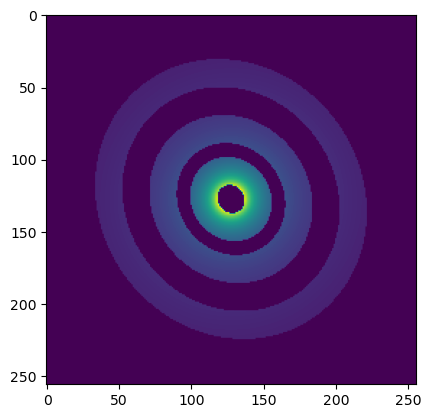

50
V
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
0.014169544482751574
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/HD71253/models/  already exists


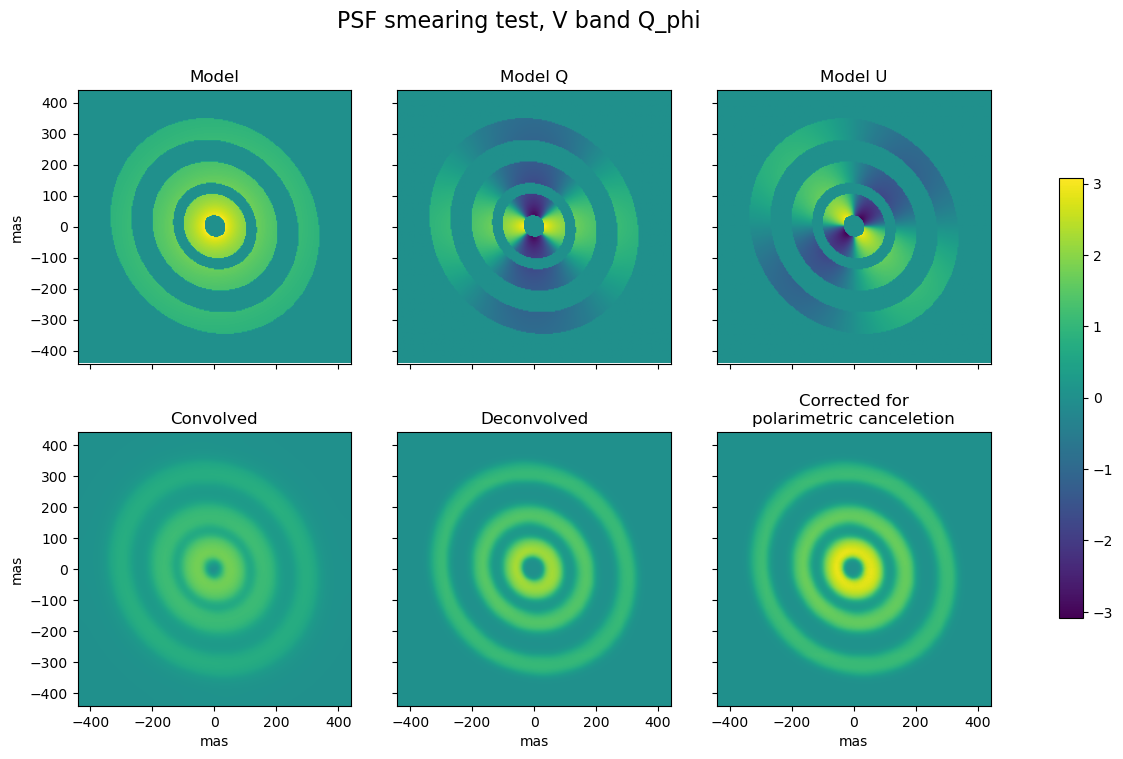

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.7622804352360195
Signal after deconvolution (as ratio to initial) 0.7628755315079597
Signal after PSF correction 0.9946039851927441
sum_PI
Signal after PSF convolution (as ratio to initial) 0.7640495304941527
Signal after PSF correction  0.9694007406845949
I
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
0.014435820002313238
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/HD71253/models/  already exists


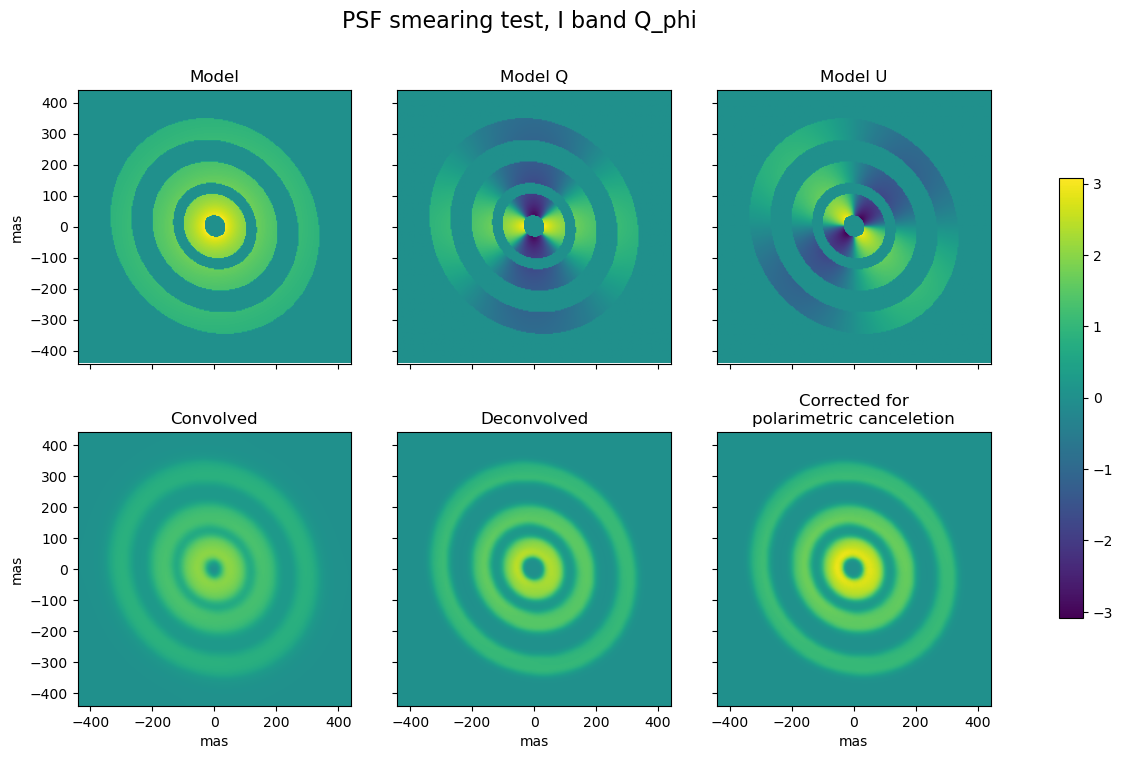

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.8402488039062833
Signal after deconvolution (as ratio to initial) 0.8408940319176691
Signal after PSF correction 0.9979599737252594
sum_PI
Signal after PSF convolution (as ratio to initial) 0.8416679858999699
Signal after PSF correction  0.987227084610483
H
256
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
deconvolution step 0
deconvolution step 1
deconvolution step 2
deconvolution step 3
deconvolution step 4
deconvolution step 5
deconvolution step 6
deconvolution step 7
deconvolution step 8
deconvolution step 9
deconvolution step 10
deconvolution step 11
deconvolution step 12
deconvolution step 13
0.014471822820651868
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_da

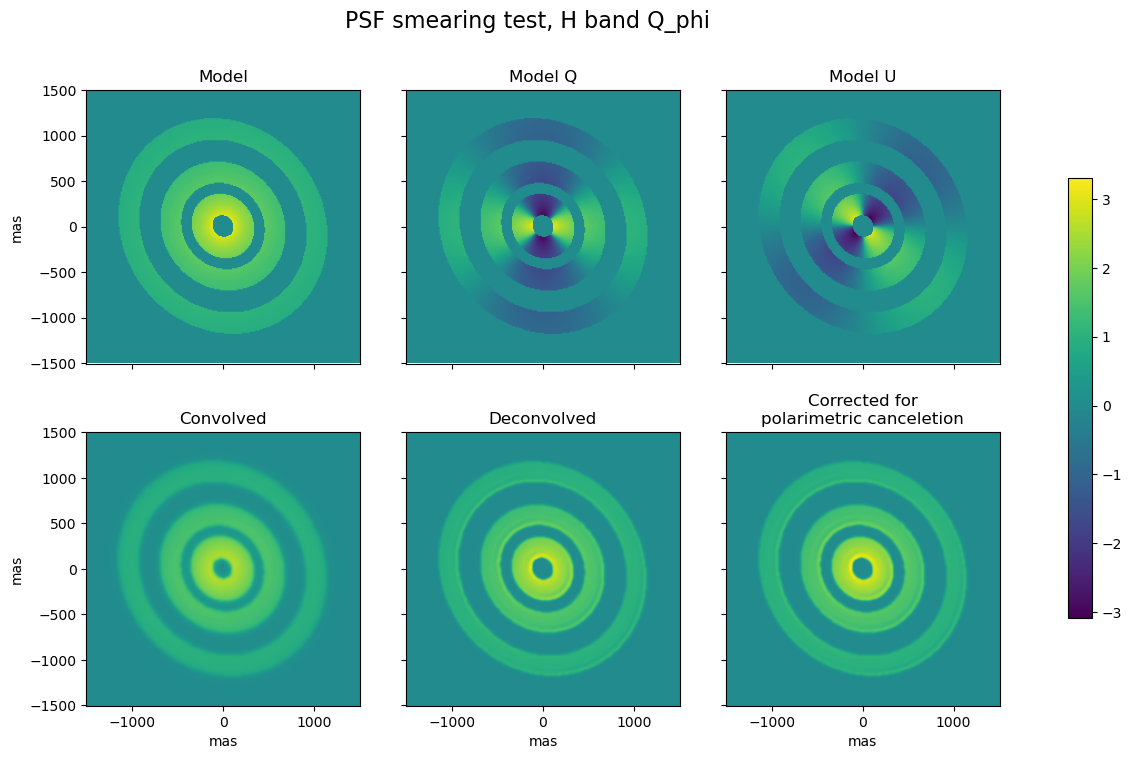

sum_Qphi
Signal after PSF convolution (as ratio to initial) 0.9452490755726362
Signal after deconvolution (as ratio to initial) 0.947038039270166
Signal after PSF correction 1.0024534746336025
sum_PI
Signal after PSF convolution (as ratio to initial) 0.9458805025363025
Signal after PSF correction  0.9998660501755597


In [31]:
import numpy as np
import matplotlib.pyplot as plt

n_model = 256
shift = int(n_model / 2)
x = np.linspace(-shift + 1, shift, num=n_model)
y = np.linspace(-shift + 1, shift, num=n_model)
x = x - 0.5
y = y - 0.5

X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
#calculating angle for azimuthal polarisation
phi= np.arctan(Y/X)
science_targ=sci_of_ref[star]
incl_pa=disk_incl_pa[science_targ]

 # Define ellipse parameters
center = (0, 0)  # Center coordinates (x, y)

position_angle = incl_pa[1]-90  # Position angle (orientation) of the ellipse (in degrees)
sini=np.cos(np.deg2rad(incl_pa[0]))

# Create an empty array for the ellipse
ellipse_ring = np.zeros((n_model, n_model))
ellipse_ring=100/R
# Calculate the ellipse mask with the specified position angle
a = np.deg2rad(position_angle)
cos_a = np.cos(a)
sin_a = np.sin(a)





axes = (100, 100*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
# Set the pixels inside the ellipse to 1
ellipse_ring[~mask] = 0




axes = (80, 80*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
# Set the pixels inside the ellipse to 1

axes = (60, 60*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
mask = mask1 & ~mask2
# Set the pixels inside the ellipse to 1
ellipse_ring[mask] = 0



axes = (40, 40*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask1 = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
# Set the pixels inside the ellipse to 1

axes = (30, 30*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
mask = mask1 & ~mask2
# Set the pixels inside the ellipse to 1
ellipse_ring[mask] = 0

axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
# Generate the ellipse mask with rotation
mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
# Set the pixels inside the ellipse to 1
ellipse_ring[mask] = 0










# axes = (100, 100*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 40

# axes = (80, 80*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 0

# axes = (60, 60*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 45

# axes = (40, (40)*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 0

# axes = (30, 30*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 50

# axes = (30-20, (30-20)*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 0













# axes = (100, 100*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)#*(np.rad2deg(phi)+180<180)*(np.rad2deg(phi)+180>120)
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 1

# axes = (80, 80*np.cos(np.deg2rad(75)))  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = (((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1)
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 0

# axes = (30, 30*sini)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 5


# axes = (30-10, 30*sini-10)  # Major and minor axis lengths
# # Generate the ellipse mask with rotation
# mask = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
# # Set the pixels inside the ellipse to 1
# ellipse_ring[mask] = 0











# Display the ellipse
plt.imshow(ellipse_ring)
plt.show()
plt.close()

ring_H=ellipse_ring

ring_H_q=ring_H*np.cos(2*phi)
ring_H_u=ring_H*np.sin(2*phi)

lim=20    

qphi=(ring_H_q*np.cos(2*phi)+ring_H_u*np.sin(2*phi))#/model_imageItot
uphi=(ring_H_q*np.sin(2*phi)-ring_H_u*np.cos(2*phi))#/model_imageItot

for psf_cut in [50]:
    print(psf_cut)
    #downloading PSF files
    if star=='HD71253' or star=='HD96314':
        image_sphere, psf_H, n,hdul= Loadimages(irdis_of_ref[star],'Q_phi')
        psf_H_short=psf_H[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
        psf_H=psf_H_short#/np.sum(psf_H_short)
        
    figfolder_psf='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+star+'/'  #For IRAS08
    psf_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    psf_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits') 
    psf_V_short=psf_V[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_I_short=psf_I[int(n/2)-psf_cut:int(n/2)+psf_cut,int(n/2)-psf_cut:int(n/2)+psf_cut]
    psf_V=psf_V_short#/np.sum(psf_V_short)
    psf_I=psf_I_short#/np.sum(psf_I_short)
  
    

    for band in bands:
        print(band)
        if band=='I':
            ps=3.6
            psf=psf_I
           
        elif band=='V':
            ps=3.6
            psf=psf_V
           
        elif band=='H':
            ps=12.27
            psf=psf_H
                 
        #f_q= Loadimage(figfolder,band+'band_qphi_circular_f_psf_'+str(psf_cut)+'.fits')
        #f_pi= Loadimage(figfolder,band+'band_pi_circular_f_psf_'+str(psf_cut)+'.fits')
        
        f_q= Loadimage(figfolder,star+band+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
        f_pi= Loadimage(figfolder,star+band+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_'+str(psf_cut)+'.fits')
        f_q=f_q[512-128:512+128,512-128:512+128]
        print(f_q.shape[0])
        f_pi=f_pi[512-128:512+128,512-128:512+128]
        
        Q_conv=convolve_fft(ring_H_q, psf, boundary='wrap')                                   
        U_conv=convolve_fft(ring_H_u, psf, boundary='wrap')#, normalize_kernel=np.sum)                                       
        PI_conv=np.sqrt(Q_conv*Q_conv+U_conv*U_conv)

        Q_phi_conv=Q_conv*np.cos(2*phi)+U_conv*np.sin(2*phi)
        Q_phi_conv=(Q_phi_conv>=0)*Q_phi_conv+(Q_phi_conv<0)*1e-16 #to clearly simulate analysis situation and look only on the azimuthal part
        U_phi_conv=Q_conv*np.sin(2*phi)-U_conv*np.cos(2*phi)
        
        PI_deconvolved, crit= deconvolving(PI_conv, psf, 25)
        
        PI_corrected=PI_deconvolved*f_pi
        
        Q_phi_deconvolved, crit= deconvolving(Q_phi_conv, psf, 25)
        print(crit)
        
        Q_phi_corrected=Q_phi_deconvolved*f_q
        #to see Q and U
        #keys=['orig','orig_q','orig_u',  'conv','decon','corr']
        #labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for PSF'}
        #data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
        #if band=='H':
        #    cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
        #else:
        #    cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']
        
        
        #without Q and U
        keys=['orig',  'conv','decon','corr']
        labels={'orig':'Model','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric canceletion'}
        data={'orig':ring_H, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
        if band=='H':
            cameras=['IRDIS','IRDIS','IRDIS','IRDIS']
        else:
            cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']
            
            
        keys=['orig','orig_q','orig_u',  'conv','decon','corr']
        labels={'orig':'Model','orig_q':'Model Q','orig_u':'Model U','conv':'Convolved','decon':'Deconvolved','corr':'Corrected for polarimetric canceletion'}
        data={'orig':ring_H,'orig_q':ring_H_q,'orig_u':ring_H_u, 'conv':Q_phi_conv,'decon':Q_phi_deconvolved,'corr':Q_phi_corrected}
        if band=='H':
            cameras=['IRDIS','IRDIS','IRDIS','IRDIS','IRDIS','IRDIS']
        else:
            cameras=['ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL','ZIMPOL']
            
            
        plot_with_same_color(data, keys, labels ,'Q_phi','PSF smearing test, '+band+ ' band',10*ps,True,cameras)

        #print('Q_phi',np.sum(Q_phi_conv))
        print('sum_Qphi')
        print('Signal after PSF convolution (as ratio to initial)',np.sum(Q_phi_conv)/np.sum(ring_H))
        print('Signal after deconvolution (as ratio to initial)',np.sum(Q_phi_deconvolved)/np.sum(ring_H))
        print('Signal after PSF correction', np.sum(Q_phi_corrected)/np.sum(ring_H))
        
        #print('Initial ', np.sum(ring_H))
        #print('Convolved',np.sum(Q_phi_conv))
        #print('Corrected',np.sum(Q_phi_corrected))
        print('sum_PI')
        print('Signal after PSF convolution (as ratio to initial)',np.sum(PI_conv)/np.sum(ring_H))
        print('Signal after PSF correction ', np.sum(PI_corrected)/np.sum(ring_H))
        #print('Initial ', np.sum(ring_H))
        #print('Convolved',np.sum(PI_conv))
        #print('Corrected',np.sum(PI_corrected))



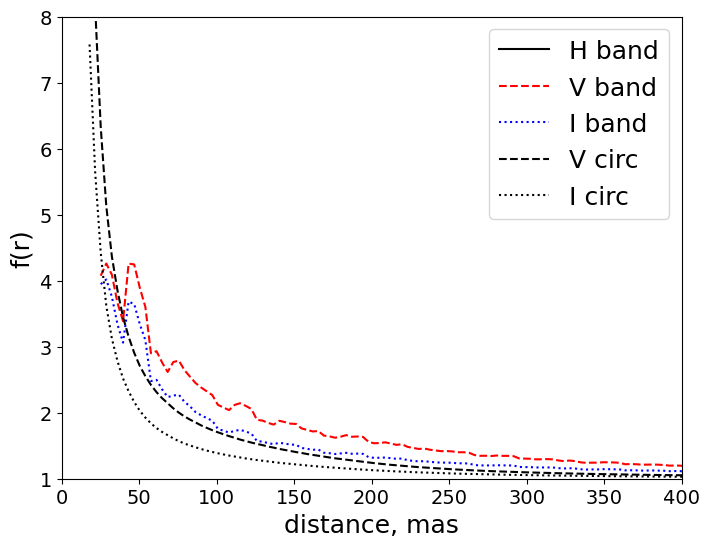

In [15]:

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
imagefolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'PSF_correction_plot/'
createfolder(imagefolder)

df_a_circ = pd.read_csv(figfolder+f'df_{psf_cut}'+'.csv')

df_a = pd.read_csv(figfolder+star+'ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'df_50'+'.csv')
fig = plt.figure(figsize=(8, 6))

plt.plot(df_a['majaxis_H'],df_a['f_H'],label='H band',color='black')
plt.plot(df_a['majaxis_V'][3:],df_a['f_V'][3:],label='V band',color='red',linestyle='dashed')
plt.plot(df_a['majaxis_I'][3:],df_a['f_I'][3:],label='I band',color='blue',linestyle='dotted')
plt.plot(df_a_circ['radius_V'][3:],df_a_circ['f_V'][3:],label='V circ',color='black',linestyle='dashed')
plt.plot(df_a_circ['radius_I'][3:],df_a_circ['f_I'][3:],label='I circ',color='black',linestyle='dotted')
#plt.title('Andrych')
plt.ylim(1,8)
plt.xlim(0,400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('distance, mas', fontsize=18)
plt.ylabel('f(r)', fontsize=18)
plt.legend(fontsize=18)
plt.savefig(imagefolder+star+'_smearing_coeff.png')
plt.show()
plt.close()
